# VGAEを活用したデータ生成
## GPU PyTorchの動作確認

In [1]:
import sys
import torch
from torch_geometric.data import Data

print("Python：" + sys.version)
print("PyTorch：" + torch.__version__)

if torch.cuda.is_available():
    print("CUDA：" + torch.version.cuda)
    print("GPU：" + torch.cuda.get_device_name(0))
else:
    print("GPU is not available.")


Python：3.12.11 (main, Jul  3 2025, 17:03:59) [GCC 11.4.0]
PyTorch：2.7.1+cu128
CUDA：12.8
GPU：NVIDIA GeForce RTX 3060


## データの取得
1. Coraグラフデータの取得
2. グラフデータの可視化
3. 取得したグラフデータをPyTorchのデータ型に変換する

In [ ]:
# networkxのグラフをtorch_geometricのDataに変換
from torch_geometric.datasets import Planetoid 
from torch_geometric.utils import (
    train_test_split_edges,
)

# Cora の citation ネットワーク (2,708 ノード / 5,429 エッジ)
data = Planetoid(root='/tmp', name='Cora')[0]
data.train_mask = data.val_mask = data.test_mask = None      # ノード分類用マスクは不要

# エッジをトレーニング、検証、テストセットに分割
data = train_test_split_edges(data)

# print("PyTorch Geometric Data:", data)
print(data.x)
print("Edge Index:", data.train_pos_edge_index)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
Edge Index: tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])


Processing...
Done!
/app/.venv/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


## VGANを活用したグラフ生成
1. Encoderの定義とモデルの作成
2. モデルの学習
3. モデルの評価
4. グラフの生成

In [3]:
from torch_geometric.nn import GCNConv, VGAE

# Encoderの定義
class GraphEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GraphEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv_mu = GCNConv(2 * out_channels, out_channels)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

in_channels = data.x.size(-1) # 入力される特徴量の次元
out_channels = 3 # 出力される特徴量の次元
print(f"入力特徴量の次元: {in_channels}, 出力特徴量の次元: {out_channels}")
model = VGAE(GraphEncoder(in_channels=in_channels, out_channels=out_channels)) # エンコーダとデコーダーを合わせてモデルのインスタンス化

入力特徴量の次元: 1433, 出力特徴量の次元: 3


In [4]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device) # 利用するデバイスを選択
data = data.to(device)  # データをGPUに転送
best_loss = float('inf') # 最良モデルの追跡用変数
best_model = None # 最良モデルの保存用変数

def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.train_pos_edge_index)
    recon_loss = model.recon_loss(z, data.train_pos_edge_index)
    kl_loss = (1 / data.num_nodes) * model.kl_loss()
    loss = recon_loss + kl_loss
    loss.backward()
    optimizer.step()
    return loss.item()

for epoch in range(1, 301):
    loss = train()
    # 現在のエポックでのlossが最良の場合、モデルを保存
    if loss < best_loss:
        best_loss = loss
        # モデルの保存
        best_model = model

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')
model = best_model  # 最良モデルを使用 


Epoch 10, Loss: 1.6398036479949951
Epoch 20, Loss: 1.307974934577942
Epoch 30, Loss: 1.1828076839447021
Epoch 40, Loss: 1.1406878232955933
Epoch 50, Loss: 1.1031218767166138
Epoch 60, Loss: 1.092420220375061
Epoch 70, Loss: 1.089751958847046
Epoch 80, Loss: 1.0799006223678589
Epoch 90, Loss: 1.07563316822052
Epoch 100, Loss: 1.088756799697876
Epoch 110, Loss: 1.0718847513198853
Epoch 120, Loss: 1.0778931379318237
Epoch 130, Loss: 1.0632153749465942
Epoch 140, Loss: 1.0565534830093384
Epoch 150, Loss: 1.0496366024017334
Epoch 160, Loss: 1.0461928844451904
Epoch 170, Loss: 1.0430985689163208
Epoch 180, Loss: 1.0315101146697998
Epoch 190, Loss: 1.0363507270812988
Epoch 200, Loss: 1.0259815454483032
Epoch 210, Loss: 1.0259029865264893
Epoch 220, Loss: 1.0178300142288208
Epoch 230, Loss: 1.0168557167053223
Epoch 240, Loss: 1.0291215181350708
Epoch 250, Loss: 1.0043545961380005
Epoch 260, Loss: 1.0196675062179565
Epoch 270, Loss: 1.021008849143982
Epoch 280, Loss: 1.009013295173645
Epoch 290

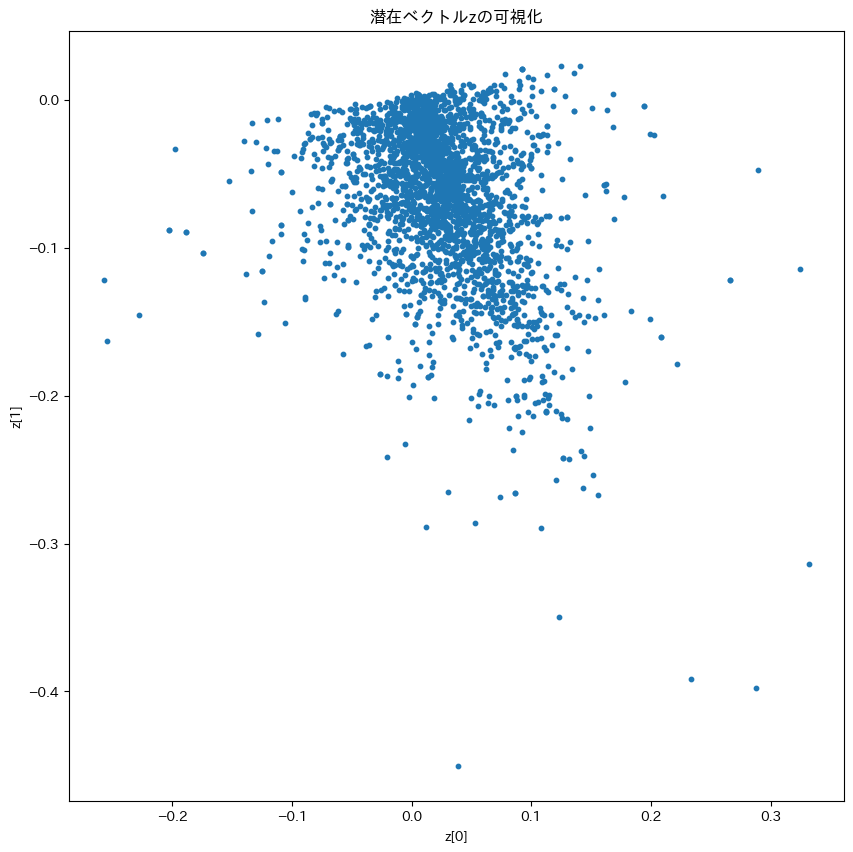

In [ ]:
import matplotlib.pyplot as plt
import japanize_matplotlib

# グラフを生成する関数
def generate_graph(model, data):
    model = VGAE(GraphEncoder(in_channels=in_channels, out_channels=out_channels))
    model = model.to(device)  # モデルをGPUに転送
    data = data.to(device)  # データをGPUに転送
    model.eval()
    with torch.no_grad():
        z = model.encode(data.x, data.train_pos_edge_index)  # エンコーダを使用して潜在ベクトルzを生成
        # 潜在ベクトルzの可視化
        plt.figure(figsize=(10, 10))
        plt.scatter(z[:, 0].cpu(), z[:, 1].cpu(), s=10)
        plt.title("潜在ベクトルzの可視化")
        plt.xlabel("z[0]")
        plt.ylabel("z[1]")
        plt.show()

        # print("z:", z)
        # 潜在ベクトルzをデコードして隣接行列を生成
        adj = z @ z.t()  # xとzの内積を計算して隣接行列を生成
        # adj = torch.matmul(z, z.t())  # 潜在ベクトルzの外積を計算して隣接行列を生成
        adj = torch.sigmoid(adj)  # Sigmoid関数を適用して隣接行列を確率に変換
        # print("prob", adj)
        tau = 0.55
        adj_matrix = (adj > tau).nonzero(as_tuple=False).t()

        return adj_matrix

# 取引0のグラフデータを作成
sample = generate_graph(model, data)

In [ ]:
import networkx as nx

g_gen = nx.DiGraph()  # 有向グラフの作成
g_gen.add_nodes_from(range(data.num_nodes))  # ノードを追加
g_gen.add_edges_from(sample.t().cpu().numpy())  # エッジを追加
print(f"生成されたグラフ: ノード数={g_gen.number_of_nodes()}, エッジ数={g_gen.number_of_edges()}")

plt.figure(figsize=(10, 10))
nx.draw(g_gen, with_labels=False)
plt.title("生成されたグラフ")
plt.show()

生成されたグラフ: ノード数=2708, エッジ数=6031427


In [ ]:
# グラフの次数分布を計算して表示
degrees = [deg for node, deg in g_gen.degree()]
degree_counts = {}

# 次数ごとの頂点数をカウント
for d in degrees:
    if d in degree_counts:
        degree_counts[d] += 1
    else:
        degree_counts[d] = 1

# 次数分布をプロット
plt.figure(figsize=(10, 6))
plt.bar(degree_counts.keys(), degree_counts.values(), color='steelblue')
plt.xlabel('次数（Degree）')
plt.ylabel('ノード数')
plt.title('グラフの次数分布')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 統計情報も表示
print(f"平均次数: {sum(degrees) / len(degrees):.2f}")
print(f"最大次数: {max(degrees)}")
print(f"最小次数: {min(degrees)}")
print(f"次数0のノード数: {degrees.count(0)}")

In [ ]:
# g_genの次数中心性・媒介中心性・PageRankを計算
centrality_df = pd.DataFrame(
    index=list(g_gen.nodes),
    columns=["degree", "betweenness", "pagerank"]
)

# 次数中心性
degree_centrality = nx.in_degree_centrality(g_gen)
centrality_df["degree"] = pd.Series(degree_centrality)
# 媒介中心性
betweenness_centrality = nx.betweenness_centrality(g_gen)
centrality_df["betweenness"] = pd.Series(betweenness_centrality)
# PageRank
pagerank_centrality = nx.pagerank(g_gen, max_iter=1000)
centrality_df["pagerank"] = pd.Series(pagerank_centrality)

display(centrality_df.head(20))

# 外れ値の除去
# 閾値を超える次数中心性を持つ行の削除
centrality_df_out = centrality_df.copy()
centrality_df_out = centrality_df_out[centrality_df_out["degree"] < 0.4]
centrality_df_out = centrality_df_out[centrality_df_out["betweenness"] < 0.4]
centrality_df_out = centrality_df_out[centrality_df_out["pagerank"] < 0.4]

In [ ]:
# 箱ひげ図でcentrality_df_outを可視化(3つとも別の図)
plt.figure(figsize=(12, 10))
plt.subplot(1, 3, 1)
centrality_df_out.boxplot(column=["degree"])
plt.title("生成グラフの次数中心性の箱ひげ図")
plt.ylabel("中心性スコア")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(1, 3, 2)
centrality_df_out.boxplot(column=["betweenness"])
plt.title("生成グラフの媒介中心性の箱ひげ図")
plt.ylabel("中心性スコア")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(1, 3, 3)
centrality_df_out.boxplot(column=["pagerank"])
plt.title("生成グラフのPageRankの箱ひげ図")
plt.ylabel("中心性スコア")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()